In [1]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch

import pandas as pd
from sklearn.model_selection import KFold
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [2]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.backbone = 'microsoft/deberta-v3-base'
        self.max_length = 512

        self.model_path = './cache'
        self.checkpoint_path = './checkpoints'
        self.dataset_path = './input/feedback-prize-english-language-learning'

        self.epoch = 0
        self.n_epochs = 3
        self.batch_size = 16

        self.n_cpus = 0
        self.n_splits = 5

        # loss function
        self.criterion = 'SmoothL1Loss'

        # optimizer
        # self.optimizer='Adam'
        self.lr = 5e-4
        self.b1 = 0.9
        self.b2 = 0.999
        self.eps = 1e-6

        # scheduler # did not use
        self.scheduler = 'CosineAnnealingWarmRestarts'
        self.T_0 = 5
        self.eta_min = 1e-6

        self.use_wandb = False


config = Config()

device = config.device
print(device)

cuda


In [3]:
if config.use_wandb:
    run = wandb.init(project='FDB3',
                     name=config.backbone,
                     config=config,
                     group=config.backbone,
                     job_type="train",
                     )

In [4]:
# download or load model & tokenizer

'''run the code below if you are running this code for the first time'''
# tokenizer = AutoTokenizer.from_pretrained(
#     pretrained_model_name_or_path=config.backbone, cache_dir=config.model_path)
# model_config = AutoConfig.from_pretrained(
#     pretrained_model_name_or_path=config.backbone,cache_dir=config.model_path,output_hidden_states=True,)

# encoder = AutoModel.from_pretrained(
#     pretrained_model_name_or_path=config.backbone,cache_dir=config.model_path)


tail = '\models--microsoft--deberta-v3-base\snapshots\8ccc9b6f36199bec6961081d44eb72fb3f7353f3'

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=config.model_path+tail)

model_config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=config.model_path+tail, output_hidden_states=True,)

encoder = AutoModel.from_pretrained(
    pretrained_model_name_or_path=config.model_path+tail)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\envs\py38\lib\site-packages\transformers\convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# load model
from Frozenbert.pool_model import Frozenbert

# create model
net = Frozenbert(model_config, encoder).to(device)

# freeze encoder
for param in net.encoder.parameters():
    param.requires_grad = False

# unfreeze last layers
# num_unfreeze=2
# for param in net.encoder.encoder.layer[-num_unfreeze:].parameters():
#     param.requires_grad = True

# count num of parameters
total = sum([param.nelement() for param in net.parameters()])
freeze = sum([param.nelement()
              for param in net.parameters() if param.requires_grad == False])
unfreeze = sum([param.nelement()
                for param in net.parameters() if param.requires_grad == True])
print('\nnum of parameters:')
print("total:%fM" % (total/1e6))
print("freeze:%fM" % (freeze/1e6))
print("unfreeze:%fM" % (unfreeze/1e6))
print("unfreeze/total:%f%%" % (unfreeze/total*100))


num of parameters:
total:184.029958M
freeze:183.831552M
unfreeze:0.198406M
unfreeze/total:0.107812%


In [6]:
# data frame
df = pd.read_csv(config.dataset_path+'/train.csv')
test_df = pd.read_csv(config.dataset_path+'/test.csv')

# Create a KFold cross-validator
kf = KFold(n_splits=config.n_splits, shuffle=True, random_state=1357)

In [7]:
from utils.classes import EssayDataset
from utils.classes import Trainer

def train_fold(model, train_df, val_df, test_df, config, epoch):
    # Prepare data
    train_ds = EssayDataset(train_df, config, tokenizer=tokenizer)
    val_ds = EssayDataset(val_df, config, tokenizer=tokenizer)
    # test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)

    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=config.batch_size, shuffle=True, num_workers=config.n_cpus, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=config.batch_size, shuffle=True, num_workers=config.n_cpus, pin_memory=True)
    # test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

    # Create a trainer and train the model
    trainer = Trainer(model=model, loaders=(
        train_loader, val_loader), config=config)

    current_lr = trainer.optimizer.param_groups[0]['lr']

    # Start training
    trainer.model.train()
    trainer.train_one_epoch(epoch)
    trainer.clear()

    trainer.model.eval()
    trainer.valid_one_epoch(epoch)
    trainer.clear()

    # Test result after training
    # preds = trainer.test(test_loader=test_loader)
    # print("Test result after training:\n", preds)

    # Calculate and return mean loss and MCRMSE
    mean_train_loss = np.mean(trainer.train_losses)
    mean_valid_loss = np.mean(trainer.valid_losses)
    mean_valid_mcrmse = np.mean(trainer.valid_mcrmse)

    print('current lr: {:.7f}'.format(current_lr))
    print('train_loss: %.2f, valid_loss: %.2f, val_mcrmse: %.2f' %
          (mean_train_loss, mean_valid_loss, mean_valid_mcrmse))

    return mean_train_loss, mean_valid_loss, mean_valid_mcrmse

In [8]:
# Lists to store results from each fold

global fold_train_losses
global fold_val_losses
global fold_val_mcrmse
global min_mcrmse
global best_model

fold_train_losses = []
fold_valid_losses = []
fold_valid_mcrmse = []
min_mcrmse = float("inf")

In [9]:
for epoch in range(config.epoch+1, config.epoch+config.n_epochs + 1):

    # Iterate over the cross-validation splits
    for fold, (train_index, val_index) in enumerate(kf.split(df)):
        print(f"{'+'*30} Fold {fold + 1}/{config.n_splits} {'+'*30}")

        train_fold_df = df.iloc[train_index]
        val_fold_df = df.iloc[val_index]

        # Train the model on the fold and store validation results
        mean_train_loss, mean_valid_loss, mean_valid_mcrmse = train_fold(
            net, train_fold_df, val_fold_df, test_df, config, epoch)

        # Store the validation loss and MCRMSE for this fold
        fold_train_losses.append(mean_train_loss)
        fold_valid_losses.append(mean_valid_loss)
        fold_valid_mcrmse.append(mean_valid_mcrmse)

        if mean_valid_mcrmse < min_mcrmse:
            min_mcrmse = mean_valid_mcrmse
            best_model = net

    print(f"{'-' * 30} EPOCH {epoch} / {config.n_epochs+config.epoch} {'-' * 30}")
    print(f"mean train loss: {np.mean(fold_train_losses)}")
    print(f"mean valid loss: {np.mean(fold_valid_losses)}")
    print(f"mean valid mcrmse: {np.mean(fold_valid_mcrmse)}\n\n")

    # save model
    save_name = '/FrozenBert-epochs%d-val_mcrmse%.4f.pth' % (epoch, min_mcrmse)
    torch.save(best_model, config.checkpoint_path+save_name)

    # wandb
    if config.use_wandb:
        wandb.log({
            "train_loss": fold_train_losses[-1],
            "valid_loss": fold_valid_losses[-1],
            "valid_mcrmse": fold_valid_mcrmse[-1], })

print('min mcrmse: ', min_mcrmse)

++++++++++++++++++++++++++++++ Fold 1/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.22, valid_loss: 0.11, val_mcrmse: 0.47
++++++++++++++++++++++++++++++ Fold 2/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.12, valid_loss: 0.12, val_mcrmse: 0.48
++++++++++++++++++++++++++++++ Fold 3/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.11, valid_loss: 0.13, val_mcrmse: 0.49
++++++++++++++++++++++++++++++ Fold 4/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.11, valid_loss: 0.15, val_mcrmse: 0.54
++++++++++++++++++++++++++++++ Fold 5/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.11, valid_loss: 0.11, val_mcrmse: 0.47
------------------------------ EPOCH 1 / 3 ------------------------------
mean train loss: 0.1351610795347666
mean valid loss: 0.12481764123147847
mean valid mcrmse: 0.49328068178527207


++++++++++++++++++++++++++++++ Fold 1/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


current lr: 0.0005000
train_loss: 0.11, valid_loss: 0.11, val_mcrmse: 0.47
++++++++++++++++++++++++++++++ Fold 2/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.11, valid_loss: 0.11, val_mcrmse: 0.46
++++++++++++++++++++++++++++++ Fold 3/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.10, valid_loss: 0.11, val_mcrmse: 0.47
++++++++++++++++++++++++++++++ Fold 4/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.11, valid_loss: 0.12, val_mcrmse: 0.47
++++++++++++++++++++++++++++++ Fold 5/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.20it/s]


current lr: 0.0005000
train_loss: 0.11, valid_loss: 0.16, val_mcrmse: 0.55
------------------------------ EPOCH 2 / 3 ------------------------------
mean train loss: 0.12074656301767242
mean valid loss: 0.12291895955496905
mean valid mcrmse: 0.4889821773889113


++++++++++++++++++++++++++++++ Fold 1/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


current lr: 0.0005000
train_loss: 0.10, valid_loss: 0.11, val_mcrmse: 0.45
++++++++++++++++++++++++++++++ Fold 2/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


current lr: 0.0005000
train_loss: 0.10, valid_loss: 0.13, val_mcrmse: 0.50
++++++++++++++++++++++++++++++ Fold 3/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


current lr: 0.0005000
train_loss: 0.10, valid_loss: 0.12, val_mcrmse: 0.48
++++++++++++++++++++++++++++++ Fold 4/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


current lr: 0.0005000
train_loss: 0.10, valid_loss: 0.10, val_mcrmse: 0.44
++++++++++++++++++++++++++++++ Fold 5/5 ++++++++++++++++++++++++++++++


100%|██████████| 49/49 [00:23<00:00,  2.07it/s]


current lr: 0.0005000
train_loss: 0.10, valid_loss: 0.12, val_mcrmse: 0.48
------------------------------ EPOCH 3 / 3 ------------------------------
mean train loss: 0.11459966647711133
mean valid loss: 0.11991392456147136
mean valid mcrmse: 0.4828651560001632


min mcrmse:  0.4422356382924683


In [10]:
# Test on best model
test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

best_model.eval()
preds = []

for inputs in test_loader:
    inputs = {k: inputs[k].to(device)for k in inputs.keys()}
    outputs = best_model(inputs)
    preds.extend(outputs.cpu().detach())

print("Final Test Predictions:\n")
for i in range(len(test_loader)):
    print('essay%d---cohesion: %.2f, syntax: %.2f, vocabulary: %.2f, phraseology: %.2f, grammar: %.2f, conventions: %.2f'
          % (i+1, preds[i][0], preds[i][1], preds[i][2], preds[i][3], preds[i][4], preds[i][5]))

Final Test Predictions:

essay1---cohesion: 3.04, syntax: 2.94, vocabulary: 3.27, phraseology: 3.21, grammar: 2.78, conventions: 2.68
essay2---cohesion: 2.85, syntax: 2.67, vocabulary: 2.96, phraseology: 2.63, grammar: 2.26, conventions: 2.85
essay3---cohesion: 3.69, syntax: 3.57, vocabulary: 3.70, phraseology: 3.76, grammar: 3.45, conventions: 3.38


In [11]:
if config.use_wandb:
    wandb.finish()

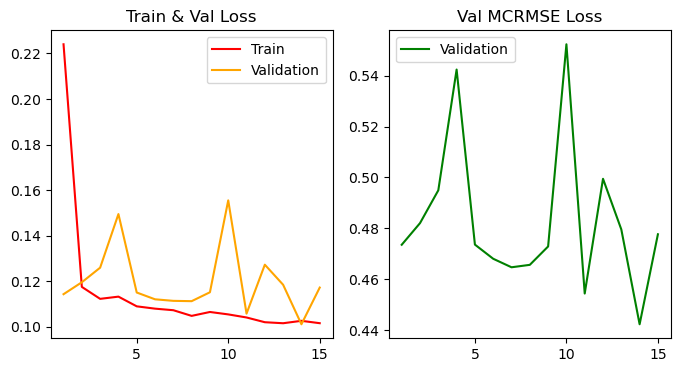

In [12]:
# plot loss
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# x_axis
xx = range(1, len(fold_train_losses)+1)

ax[0].plot(xx, fold_train_losses, color='red')
ax[0].plot(xx, fold_valid_losses, color='orange')
ax[0].set_title('Train & Val Loss')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(xx, fold_valid_mcrmse,  color='green')
ax[1].set_title('Val MCRMSE Loss')
ax[1].legend(['Validation'], loc='best')

plt.show()